In [1]:
from pathlib import Path
from skimage.draw import ellipse
from skimage.exposure import rescale_intensity
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.io import imshow
from skimage.measure import find_contours
from skimage.measure import label
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.transform import rotate
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
def workflow(fname, sigma=10, cutoff=20):
    """ Mostly automated quantification (play with sigma). """
    img0 = imread(fname, as_gray=True)
    img1 = gaussian(img0, sigma=sigma)
    img2 = rescale_intensity(img1, out_range=(-1, 1))
    img4 = img1 > threshold_otsu(img1)
    
    label_img = label(1 - img4)
    regions = regionprops(label_img)

    porosity = 100 * (1 - img4.sum() / img0.size)
    contours = find_contours(img4, 0.99)

    plt.close("all")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.set_title(f"Automated porosity of {porosity:.1f}%")
    ax.imshow(img0, cmap="gray")

    for c in contours:
        ax.plot(c[:, 1], c[:, 0], color="y", linewidth=1)

    for props in regions:
        if props.area < cutoff:
            continue

        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
        y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
        x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
        y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length

        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)
        ax.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=1)
    
    ax.axis("off")
    fig.tight_layout()
    plt.savefig(f"{Path(fname).stem}-result-auto.png")
    # plt.close("all")
    
    properties = (
        "area",
        'axis_major_length',
        'axis_minor_length',
        'centroid',
        "eccentricity",
        "equivalent_diameter_area",
        "feret_diameter_max",
        'orientation',
        "perimeter",
        "perimeter_crofton"
        )
    table = regionprops_table(label_img, properties=properties)
    table = pd.DataFrame(table)
    return table

In [3]:
all_files = Path("media/014-Image-Analysis-Region-Props").glob("*.jpg")
all_files = list(all_files)

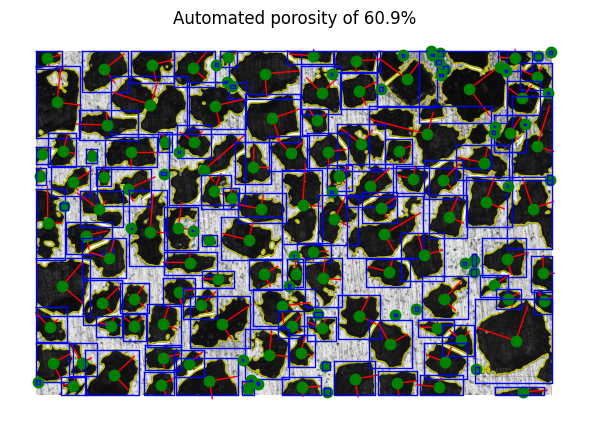

In [4]:
table = workflow(all_files[1])

In [5]:
table

,area,axis_major_length,axis_minor_length,centroid-0,centroid-1,eccentricity,equivalent_diameter_area,feret_diameter_max,orientation,perimeter,perimeter_crofton
0,35114,283.923572,173.736052,76.037734,107.597112,0.790926,211.443925,287.445647,-1.308597,812.190909,772.686783
1,132747,507.460080,348.679110,186.532652,683.578070,0.726557,411.118876,527.443836,-0.904076,1523.709812,1447.249001
2,101278,430.816791,315.574560,137.992841,1167.388386,0.680764,359.097695,454.942854,-1.359311,1463.543289,1387.526044
3,100797,436.371665,314.634763,175.711906,1572.499350,0.692909,358.243948,498.811588,-0.698345,1453.804220,1381.170694
4,239945,672.125267,461.353858,230.290767,2297.761762,0.727214,552.727295,715.234227,-1.486729,2034.292639,1931.311876
...,...,...,...,...,...,...,...,...,...,...,...
152,10122,145.838840,105.651268,3396.303102,2129.080024,0.689339,113.524141,149.201206,0.460002,527.546248,502.826722
153,471,29.032937,20.671702,3346.373673,2229.811040,0.702171,24.488688,29.732137,-0.175978,79.941125,78.470456
154,2,2.000000,0.000000,3340.500000,4502.000000,1.000000,1.595769,2.000000,0.000000,0.000000,4.577636
155,25341,475.962508,74.974354,3425.437552,4895.774318,0.987516,179.625063,492.468273,-1.523040,1077.788889,1024.489457
